## Instructions

This is an end-to-end sample machine learning workflow purely written in Jupyter Notebook, you will create a classifier to distinguish span emails (junk, unsolicited bulk or commercial messages) from han (non-spam) emails.

It aims to help us get familiar with Jupyter Notebook, and some common library used by data scientist (i.e. pandas, matplotlib, sk-learn)

1. The dataset is publicly available https://www.kaggle.com/competitions/ds100fa19, which is originally a course project for UC Berkeley Data 100 course [Principles and Techniques of Data Science](https://ds100.org/).
2. We can complete this lab in any Jupyter Lab or Jupyter Notebooks locally. (Not necessary in Kubeflow)
3. Press `Shift + Enter` to execute a cell and print result

In [44]:
%%bash

# install libraries we will use
pip install pandas
pip install matplotlib
pip install sklearn
pip install numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## 1. Data collection

Please visit the Kaggle website https://www.kaggle.com/competitions/ds100fa19/data, click **Join Competition**, and then download the dataset. We only need training set `train.csv` for our purpose, since there is no `spam` label in `test.csv`.

This is the introduction of the data:
1. `id`: An identifier for the training example
2. `subject`: The subject of the email
3. `email`: The text of the email
4. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

In [45]:
# most widely used Python library for data anaylsis/processing
import pandas as pd

# please make sure PATH_TO_TRAIN_CSV is correct
PATH_TO_TRAIN_CSV="./train.csv"

# use pandas to read data from a csv file
email = pd.read_csv(PATH_TO_TRAIN_CSV)
# take a look at the data
email.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## 2. Data cleaning

#### 2.1 Replace missing values in text with empty string

Check the number of missing values in both `subject` and `email` columns

In [46]:
print(email['subject'].isnull().sum(), 'subject contains missing values')
print(email['email'].isnull().sum(), 'email text contains missing values')

6 subject contains missing values
0 email text contains missing values


Fill the missing values with empty string `''`

In [47]:
email['subject'] = email['subject'].fillna('')

Check again

In [48]:
print(email['subject'].isnull().sum(), 'subject contains missing values')
print(email['email'].isnull().sum(), 'email text contains missing values')

0 subject contains missing values
0 email text contains missing values


#### 2.2 Combine text columns

To make our easier, we will combine `subject` and `email` into one `text` column

In [49]:
email['text'] = email['subject'] + '\n' + email['email']

Take the first piece of the email as an example, and check if our operation succeed 

In [50]:
# Take the first piece of email as an example
i = 0
print("[subject]")
print(email['subject'][i])

print("[email]")
print(email['email'][i])

print("[text]")
print(email['text'][i])

[subject]
Subject: A&L Daily to be auctioned in bankruptcy

[email]
URL: http://boingboing.net/#85534171
 Date: Not supplied
 
 Arts and Letters Daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. A&L Daily will be auctioned off by the 
 receivers. Link[1] Discuss[2] (_Thanks, Misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/H/ZLfTeRjnD6Jf
 
 

[text]
Subject: A&L Daily to be auctioned in bankruptcy

URL: http://boingboing.net/#85534171
 Date: Not supplied
 
 Arts and Letters Daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. A&L Daily will be auctioned off by the 
 receivers. Link[1] Discuss[2] (_Thanks, Misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/H/ZLfTeRjnD6Jf
 
 



We don't care about `id` column, and we don't need `subject` and `email` anymore

Let's drop them

In [51]:
email.drop(['id', 'subject', 'email'], axis=1, inplace=True)
email.head()

,spam,text
0,0,Subject: A&L Daily to be auctioned in bankrupt...
1,0,"Subject: Wired: ""Stronger ties between ISPs an..."
2,1,Subject: It's just too small ...
3,0,Subject: liberal defnitions\n\nDepends on how ...
4,0,Subject: RE: [ILUG] Newbie seeks advice - Suse...


Now it's much clear now. 

Our task is to use `text` to predict `spam`.

#### 2.3 A little preprocessing

A word with capital letters or lowercase letters are different in terms of computer character encoding, but they all have the same meaning. 

We will convert all string to lowercase.

In [52]:
email['text'] = email['text'].str.lower()

email.head()

,spam,text
0,0,subject: a&l daily to be auctioned in bankrupt...
1,0,"subject: wired: ""stronger ties between isps an..."
2,1,subject: it's just too small ...
3,0,subject: liberal defnitions\n\ndepends on how ...
4,0,subject: re: [ilug] newbie seeks advice - suse...


## 3. Traning Validation Split

We will use the training data for both `model training` and `validating`. So we will split the data into two parts called `training set` and `validation set`

In [53]:
from sklearn.model_selection import train_test_split

training_set, validation_set = train_test_split(email, test_size=0.33, random_state=42)

# reset index from 0 to len - 1
training_set.reset_index(drop=True, inplace=True)
validation_set.reset_index(drop=True, inplace=True)

print(training_set)

print(validation_set)

      spam                                               text
0        0  subject: acopia networks?\n\nyet another pre-i...
1        0  subject: the walls are alive with the sound of...
2        1  subject: (no subject)\n\n\n <!doctype html pub...
3        0  subject: ms's palladium: what the hell is it? ...
4        1  subject: ruin anyone anywhere anything\n\ni ha...
...    ...                                                ...
5588     0  subject: [spambayes] understanding high false ...
5589     1  subject: reach millions on the internet!!\n\n\...
5590     0  subject: facts about sex.\n\n\n forwarded-by: ...
5591     0  subject: re: zoot apt/openssh & new dvd playin...
5592     0  subject: re: internet radio - example from a c...

[5593 rows x 2 columns]
      spam                                               text
0        0  subject: re: my brain hurts\n\n> someone tell ...
1        0  subject: re: [fwd: error exmh 2.5 07/13/2001 ]...
2        0  subject: re: [ilug] how to copy s

From now on, we will not touch `validation set` anymore until the we use `validation set` to assess the performance of our classifier.

## 4. Exploratory Data Analysis (EDA)

#### 4.1 The basic statistics

In [54]:
# total number
print('There are', len(training_set), 'emails')
# Positive sample: spam email
print('Positive samples:', training_set['spam'].value_counts()[1], 'emails')
# Negative sample: ham email
print('Negative samples:', training_set['spam'].value_counts()[0], 'emails')

There are 5593 emails
Positive samples: 1432 emails
Negative samples: 4161 emails


#### 4.2 Text length distribution

<AxesSubplot: ylabel='Frequency'>

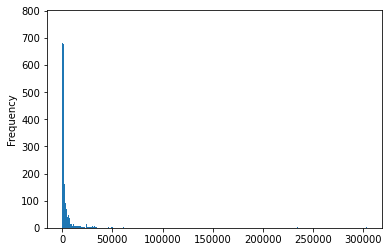

In [55]:
training_set['text_length'] = training_set['text'].str.len()
training_set['text_length'].plot.hist(bins=1000)

#### 4.3 Text length distribution by classes

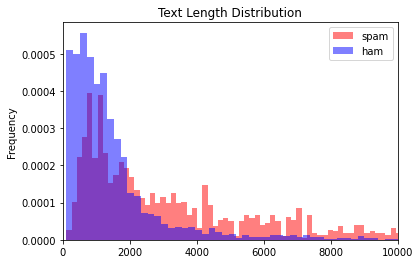

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

spam_text_length = training_set.loc[training_set.spam==1, 'text_length']
ham_text_length = training_set.loc[training_set.spam==0, 'text_length']

plt.hist(spam_text_length, alpha=0.5, density=True, bins=1500, color='red', label='spam')
plt.hist(ham_text_length, alpha=0.5, density=True, bins=1500, color='blue', label='ham')

plt.gca().set(title='Text Length Distribution', ylabel='Frequency')
plt.xlim(0,10000)
plt.legend();                   

It seems `spam` email is generally longer than `ham` email

#### 4.4 High frequency words

Let's see what kinds of words appear most frequently in `spam` email

In [57]:
spam_email = training_set[training_set.spam==1]
spam_email_text = spam_email['text']
pd.Series(' '.join(spam_email_text).split()).value_counts()[:20]

the      15103
to       14451
and      10718
of        9179
you       8899
a         7314
=         6242
your      6205
for       6179
<td       5784
in        5488
this      5084
is        5041
</tr>     3494
that      3021
i         3008
with      2988
or        2943
on        2941
are       2916
dtype: int64

What kinds of words appear most frequently in `ham` email?

In [58]:
ham_email = training_set[training_set.spam==0]
ham_email_text = ham_email['text']
pd.Series(' '.join(ham_email_text).split()).value_counts()[:20]

the     48811
>       38156
to      29186
a       22661
and     22117
of      21957
in      15211
is      13165
for     12196
that    11039
i       10060
on       8844
it       8600
<td      8121
you      7677
this     7390
with     7101
be       5852
<a       5376
as       5374
dtype: int64

I think some words can be great features too

## 5. Feature Extraction

We will notice that most features come from the process of EDA (exploratory data analysis)

#### 5.1 Feature #1: whether `text length` is shorter than `500`

In [59]:
training_set['short_text'] = training_set['text_length'] < 500

validation_set['short_text'] = validation_set['text'].str.len() < 500

#### 5.2 Feature #2: whether high frequency words appears

In [60]:
high_frequency_words = ["body", "business", "html", "money"]

for word in high_frequency_words:
    training_set[word] = training_set['text'].str.contains(word)
    validation_set[word] = validation_set['text'].str.contains(word)

## 6. Train a model

#### 6.1 Extract feature and labels from training set and validation set

In [61]:
X_train = training_set[['short_text'] + high_frequency_words]
y_train = training_set['spam']

X_val = validation_set[['short_text'] + high_frequency_words]
y_val = validation_set['spam']

#### 6.2 Take a look at our data now

In [62]:
X_train

,short_text,body,business,html,money
0,True,False,False,False,False
1,True,False,False,False,False
2,False,True,False,True,True
3,False,True,False,True,False
4,False,False,False,True,False
...,...,...,...,...,...
5588,False,False,False,False,False
5589,False,False,True,False,True
5590,False,True,False,False,False
5591,False,False,False,False,False


In [63]:
y_train

0       0
1       0
2       1
3       0
4       1
       ..
5588    0
5589    1
5590    0
5591    0
5592    0
Name: spam, Length: 5593, dtype: int64

In [64]:
X_val

,short_text,body,business,html,money
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
2750,True,False,False,False,False
2751,False,False,False,False,False
2752,False,False,False,False,False
2753,False,False,False,False,False


In [65]:
y_val

0       0
1       0
2       0
3       0
4       0
       ..
2750    1
2751    0
2752    0
2753    0
2754    0
Name: spam, Length: 2755, dtype: int64

#### 6.3 Use LogisticRegression to train a model

In [66]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#### 6.4 How does the model predict?

In [67]:
print('Classes:', clf.classes_)
print('Features:', clf.n_features_in_)
print('Coef:', clf.coef_)
print('intercept:', clf.intercept_)

def predict_with_formula(feature):
    print('-' * 50)
    print('The feature is', feature)
    ans = 0
    formula_x, formula_feature = [], []
    for i in range(clf.n_features_in_):
        formula_x.append('x' + str(i) + ' * ' + str(round(clf.coef_[0, i], 2)))
        formula_feature.append(str(feature[i]) + ' * ' + str(round(clf.coef_[0, i], 2)))
        ans += feature[i] * round(clf.coef_[0, i], 2)
    
    intercept = round(clf.intercept_[0], 2)
    ans += intercept

    if intercept > 0:
        intercept_str = '+ ' + str(intercept)
    else:
        intercept_str = '- ' + str(intercept)[1:]

    print('  ', ' + '.join(formula_x), intercept_str)
    print('= ', ' + '.join(formula_feature), intercept_str)
    if ans >= 0:
        print('= ', str(ans), '>', 0)
        print('= ', 'Spam')
        return 1
    else:
        print('= ', str(ans), '<', 0)
        print('= ', 'Ham')
        return 0

Classes: [0 1]
Features: 5
Coef: [[-1.26397282  1.19517535  0.56136658  0.98459698  1.05689114]]
intercept: [-1.91835065]


In [68]:
# play with it to see whether the model predicts according to the formula above
features = [
    [0, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 1], 
    [0, 1, 0, 0, 1], 
    [0, 1, 1, 1, 1],
    [1, 1, 1, 1, 1], 
]

[predict_with_formula(x) for x in features]

--------------------------------------------------
The feature is [0, 0, 0, 0, 0]
   x0 * -1.26 + x1 * 1.2 + x2 * 0.56 + x3 * 0.98 + x4 * 1.06 - 1.92
=  0 * -1.26 + 0 * 1.2 + 0 * 0.56 + 0 * 0.98 + 0 * 1.06 - 1.92
=  -1.92 < 0
=  Ham
--------------------------------------------------
The feature is [1, 0, 0, 0, 0]
   x0 * -1.26 + x1 * 1.2 + x2 * 0.56 + x3 * 0.98 + x4 * 1.06 - 1.92
=  1 * -1.26 + 0 * 1.2 + 0 * 0.56 + 0 * 0.98 + 0 * 1.06 - 1.92
=  -3.1799999999999997 < 0
=  Ham
--------------------------------------------------
The feature is [1, 0, 1, 1, 1]
   x0 * -1.26 + x1 * 1.2 + x2 * 0.56 + x3 * 0.98 + x4 * 1.06 - 1.92
=  1 * -1.26 + 0 * 1.2 + 1 * 0.56 + 1 * 0.98 + 1 * 1.06 - 1.92
=  -0.5799999999999998 < 0
=  Ham
--------------------------------------------------
The feature is [0, 1, 0, 0, 1]
   x0 * -1.26 + x1 * 1.2 + x2 * 0.56 + x3 * 0.98 + x4 * 1.06 - 1.92
=  0 * -1.26 + 1 * 1.2 + 0 * 0.56 + 0 * 0.98 + 1 * 1.06 - 1.92
=  0.33999999999999986 > 0
=  Spam
-------------------------

[0, 0, 0, 1, 1, 1]

## 7 Model Assessment

#### 7.1 overall accuracy

In [69]:
clf.predict(X_val)

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
print("the overall accuracy:", clf.score(X_val, y_val))

the overall accuracy: 0.8174228675136116


#### 7.2 Confusion Matrix

Confusion Matrix: to see if model predict all the samples to be `ham` (will still get an good accuracy of (1887+160)/(1887+160+343+365) = 74%)

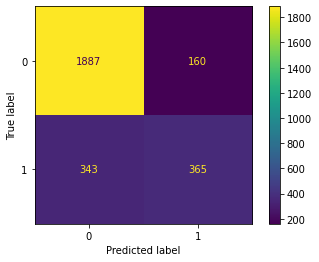

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_val, clf.predict(X_val), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

#### 7.3 ROC, AUC

`ROC` curve evaluate the model performance with difference `threshold` (instead of `0`)

`AUC`: 0.5: random guess, 0.85: acceptable, 1: perfect

/Users/jinhengxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


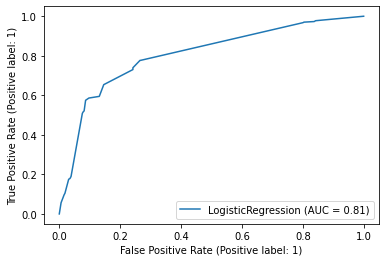

In [72]:
import matplotlib.pyplot as plt
from sklearn import metrics
metrics.plot_roc_curve(clf, X_val, y_val) 
plt.show()

## Save the data for the next lab

Run the cell below to save `training set` and `validation set`, which will be used as the input data for the next lab.

In [73]:
import numpy as np

np.save("X_train.npy", X_train.to_numpy().astype(np.float32))
np.save("y_train.npy", y_train.to_numpy().astype(np.int64))

np.save("X_val.npy", X_val.to_numpy().astype(np.float32))
np.save("y_val.npy", y_val.to_numpy().astype(np.int64))